
Siamdhani Nurcahyo

siamdhani.nurcahyo1@gmail.com

In [ ]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset

100% 379M/380M [00:22<00:00, 22.5MB/s]
100% 380M/380M [00:22<00:00, 18.1MB/s]


In [ ]:
!unzip augmented-alzheimer-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: OriginalDataset/NonDemented/31 (10).jpg  
  inflating: OriginalDataset/NonDemented/31 (100).jpg  
  inflating: OriginalDataset/NonDemented/31 (11).jpg  
  inflating: OriginalDataset/NonDemented/31 (12).jpg  
  inflating: OriginalDataset/NonDemented/31 (13).jpg  
  inflating: OriginalDataset/NonDemented/31 (14).jpg  
  inflating: OriginalDataset/NonDemented/31 (15).jpg  
  inflating: OriginalDataset/NonDemented/31 (16).jpg  
  inflating: OriginalDataset/NonDemented/31 (17).jpg  
  inflating: OriginalDataset/NonDemented/31 (18).jpg  
  inflating: OriginalDataset/NonDemented/31 (19).jpg  
  inflating: OriginalDataset/NonDemented/31 (2).jpg  
  inflating: OriginalDataset/NonDemented/31 (20).jpg  
  inflating: OriginalDataset/NonDemented/31 (21).jpg  
  inflating: OriginalDataset/NonDemented/31 (22).jpg  
  inflating: OriginalDataset/NonDemented/31 (23).jpg  
  inflating: OriginalDataset/NonDemented/31 (24).jpg  
  inflating: O

In [ ]:
#Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
data = "AugmentedAlzheimerDataset"

In [ ]:
image_dir = Path(data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("AugmentedAlzheimerDataset").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [ ]:
image_df

,Filepath,Label
0,AugmentedAlzheimerDataset/NonDemented/f8da7e1a...,NonDemented
1,AugmentedAlzheimerDataset/NonDemented/171d9daa...,NonDemented
2,AugmentedAlzheimerDataset/NonDemented/137a9d4d...,NonDemented
3,AugmentedAlzheimerDataset/NonDemented/08265f33...,NonDemented
4,AugmentedAlzheimerDataset/NonDemented/081b3ffc...,NonDemented
...,...,...
33979,AugmentedAlzheimerDataset/VeryMildDemented/12b...,VeryMildDemented
33980,AugmentedAlzheimerDataset/VeryMildDemented/14f...,VeryMildDemented
33981,AugmentedAlzheimerDataset/VeryMildDemented/6f6...,VeryMildDemented
33982,AugmentedAlzheimerDataset/VeryMildDemented/c13...,VeryMildDemented


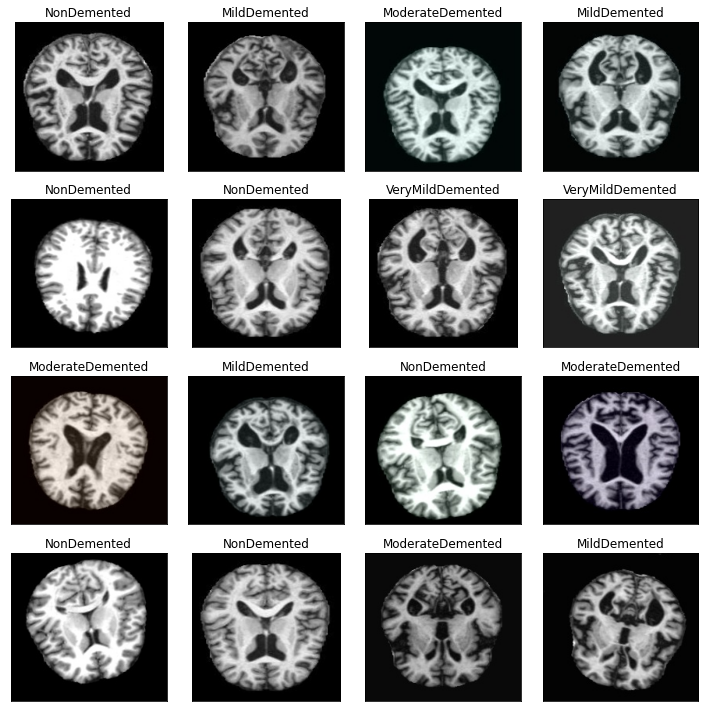

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
train_datagen_prep = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                horizontal_flip=True,
                shear_range=0.2,
                fill_mode='nearest',
                validation_split=0.2)

validation_datagen_prep = ImageDataGenerator(
               rescale=1./255,
               validation_split=0.2)

In [ ]:
data_train_generator = train_datagen_prep.flow_from_directory(
    data,
    target_size=(150, 130), 
    batch_size = 32,
    class_mode = 'categorical', #lebih dari 3 kelas
    subset = 'training')

data_validation_generator = validation_datagen_prep.flow_from_directory(
    data,
    target_size=(150, 130),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation') #karena ada validation_split di ImageDataGenerator

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.


In [ ]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape=(150, 130, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_192 (Conv2D)         (None, 148, 128, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_193 (Conv2D)         (None, 72, 62, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_194 (Conv2D)         (None, 34, 29, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 14, 64)      

In [ ]:
cnn_model.compile(
              loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
Accuracy_Threshold = 0.90
class this_myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') >= Accuracy_Threshold and logs.get('val_accuracy') >= Accuracy_Threshold):   
          print('\n')
          print('Epoch: ',epoch)
          print("\nReached %2.2f%% accuracy, training stopped!!" %(Accuracy_Threshold*100))   
          self.model.stop_training = True

callbacks = this_myCallback()

In [ ]:
history = cnn_model.fit(
    data_train_generator,
    steps_per_epoch = len(data_train_generator),
    epochs = 20,
    validation_data = data_validation_generator,
    validation_steps = len(data_validation_generator),
    verbose  =2,
    callbacks = [callbacks]
)

Epoch 1/20
850/850 - 139s - loss: 0.4917 - accuracy: 0.7868 - val_loss: 0.3868 - val_accuracy: 0.8374 - 139s/epoch - 163ms/step
Epoch 2/20
850/850 - 139s - loss: 0.4434 - accuracy: 0.8061 - val_loss: 0.3585 - val_accuracy: 0.8415 - 139s/epoch - 163ms/step
Epoch 3/20
850/850 - 139s - loss: 0.4072 - accuracy: 0.8224 - val_loss: 0.3081 - val_accuracy: 0.8724 - 139s/epoch - 163ms/step
Epoch 4/20
850/850 - 138s - loss: 0.3684 - accuracy: 0.8447 - val_loss: 0.3132 - val_accuracy: 0.8634 - 138s/epoch - 162ms/step
Epoch 5/20
850/850 - 138s - loss: 0.3442 - accuracy: 0.8542 - val_loss: 0.2802 - val_accuracy: 0.8789 - 138s/epoch - 163ms/step
Epoch 6/20
850/850 - 138s - loss: 0.3160 - accuracy: 0.8692 - val_loss: 0.2466 - val_accuracy: 0.8960 - 138s/epoch - 163ms/step
Epoch 7/20
850/850 - 138s - loss: 0.2943 - accuracy: 0.8769 - val_loss: 0.2457 - val_accuracy: 0.9020 - 138s/epoch - 163ms/step
Epoch 8/20
850/850 - 138s - loss: 0.2789 - accuracy: 0.8858 - val_loss: 0.2022 - val_accuracy: 0.9186 - 

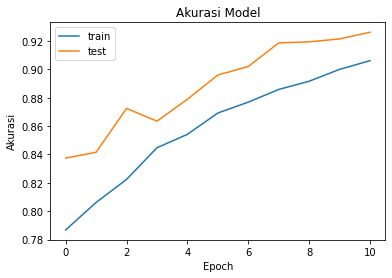

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(['train', 'test'], loc = 'upper left')

plt.show()

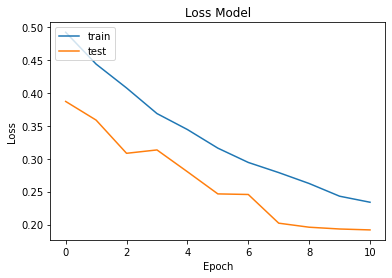

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc = 'upper left')

plt.show()

In [ ]:
import pathlib

export_directory = 'saved_model/'
tf.saved_model.save(cnn_model, export_directory)
 
converter = tf.lite.TFLiteConverter.from_saved_model(export_directory)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('alzheimer_model.tflite')
tflite_model_file.write_bytes(tflite_model)

5893124